# Exploratory Data Analysis & Preprocessing

(1) Data Loading & Understanding
    
(2) Data Cleaning & Preprocessing  
    
(3) Feature Engineering & Analysis
    
(4) Target & Relationship Analysis
    
(5) Export & Summary

<hr>

## (1) Data Loading & Understanding

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Constant
EXCLUDE_COLS = ["SalePrice", "Id"]  # Target and identifier

# Load the datasets
train_df = pd.read_csv("raw-data/train.csv")
test_df = pd.read_csv("raw-data/test.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(
    f"Total features: {train_df.shape[1] - 2}"
)  # Excluding target variable and identifier

Training data shape: (1460, 81)
Test data shape: (1459, 80)
Total features: 79


In [2]:
# Combine datasets for consistent preprocessing
# No data leakage as we're only doing type conversions and domain-based imputations
df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print(f"Combined dataset shape: {df_all.shape}")

# Quick overview of the data
df_all.head()

Combined dataset shape: (2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [3]:
# Check data types and missing values
print("Data Types Overview:")
print(df_all.dtypes.value_counts())

columns_to_analyze = df_all.columns.drop(EXCLUDE_COLS, errors="ignore")
missing_summary = df_all[columns_to_analyze].isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(f"\nFeatures with missing values: {len(missing_summary)}")

Data Types Overview:
object     43
int64      26
float64    12
Name: count, dtype: int64

Features with missing values: 34


Based on the data description, some features that appear numerical are actually categorical identifiers.

In [4]:
# Convert features that should be categorical
numerical_to_categorical = ["MSSubClass", "MoSold"]
df_all[numerical_to_categorical] = df_all[numerical_to_categorical].astype("object")

print("Converted to categorical:")
for col in numerical_to_categorical:
    print(f"- {col}")

Converted to categorical:
- MSSubClass
- MoSold


<hr>

## (2) Data Cleaning & Preprocessing

### (2.1) Domain-Based Missing Value Imputation

Many missing values in this dataset represent the absence of a feature (e.g., no pool, no garage). Based on the data description, we can impute these with "N/A" to indicate absence.

In [5]:
# Features where missing values mean "Not Applicable" or "None"
na_impute_features = [
    "Alley",  # No alley access
    "BsmtCond",  # No basement
    "BsmtExposure",  # No basement
    "BsmtFinType1",  # No basement
    "BsmtFinType2",  # No basement
    "FireplaceQu",  # No fireplace
    "GarageType",  # No garage
    "GarageFinish",  # No garage
    "GarageQual",  # No garage
    "GarageCond",  # No garage
    "PoolQC",  # No pool
    "Fence",  # No fence
    "MiscFeature",  # No miscellaneous feature
]

print(f"Imputing {len(na_impute_features)} features with 'NA' for missing values")

for feature in na_impute_features:
    missing_count = df_all[feature].isnull().sum()
    if missing_count > 0:
        df_all[feature] = df_all[feature].fillna("NA")
        print(f"  {feature}: {missing_count} missing values -> 'NA'")
    else:
        print(f"  {feature}: No missing values")

# Verify imputation worked
verification_missing = df_all[na_impute_features].isnull().sum().sum()
if verification_missing == 0:
    print("All domain-based imputation completed successfully")
else:
    print(f"Warning: {verification_missing} values still missing after imputation")

Imputing 13 features with 'NA' for missing values
  Alley: 2721 missing values -> 'NA'
  BsmtCond: 82 missing values -> 'NA'
  BsmtExposure: 82 missing values -> 'NA'
  BsmtFinType1: 79 missing values -> 'NA'
  BsmtFinType2: 80 missing values -> 'NA'
  FireplaceQu: 1420 missing values -> 'NA'
  GarageType: 157 missing values -> 'NA'
  GarageFinish: 159 missing values -> 'NA'
  GarageQual: 159 missing values -> 'NA'
  GarageCond: 159 missing values -> 'NA'
  PoolQC: 2909 missing values -> 'NA'
  Fence: 2348 missing values -> 'NA'
  MiscFeature: 2814 missing values -> 'NA'
All domain-based imputation completed successfully


### (2.2) Ordinal Feature Encoding

Many features are ordinal with a clear quality/condition ranking. We'll convert these to numerical scales.

In [6]:
# Define ordinal mappings based on data description
quality_5_scale = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_with_na = {"NA": 0, **quality_5_scale}
basement_finish = {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}

# Define all ordinal mappings
ordinal_mappings = {
    # Quality features (5-point scale)
    "ExterQual": quality_5_scale,
    "ExterCond": quality_5_scale,
    "HeatingQC": quality_5_scale,
    "KitchenQual": quality_5_scale,
    # Quality features with NA (6-point scale including NA)
    "BsmtQual": quality_with_na,
    "BsmtCond": quality_with_na,
    "FireplaceQu": quality_with_na,
    "GarageQual": quality_with_na,
    "GarageCond": quality_with_na,
    # Basement finish types
    "BsmtFinType1": basement_finish,
    "BsmtFinType2": basement_finish,
    # Unique mappings
    "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
    "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
    "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
    "Functional": {
        "Sal": 1,
        "Sev": 2,
        "Maj2": 3,
        "Maj1": 4,
        "Mod": 5,
        "Min2": 6,
        "Min1": 7,
        "Typ": 8,
    },
    "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
    "PavedDrive": {"N": 1, "P": 2, "Y": 3},
    "PoolQC": {"NA": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
}

# Sensible defaults based on domain knowledge
domain_defaults = {
    "ExterQual": 3,  # TA = Typical/Average exterior quality
    "ExterCond": 3,  # TA = Typical/Average exterior condition
    "HeatingQC": 3,  # TA = Typical/Average heating quality
    "KitchenQual": 3,  # TA = Typical/Average kitchen quality
    "BsmtQual": 0,  # NA = No basement (most conservative)
    "BsmtCond": 0,  # NA = No basement
    "FireplaceQu": 0,  # NA = No fireplace (common)
    "GarageQual": 0,  # NA = No garage (conservative)
    "GarageCond": 0,  # NA = No garage
    "BsmtFinType1": 0,  # NA = No basement
    "BsmtFinType2": 0,  # NA = No basement
    "LotShape": 4,  # Reg = Regular (most common)
    "LandSlope": 3,  # Gtl = Gentle (most common)
    "BsmtExposure": 0,  # NA = No basement
    "Functional": 8,  # Typ = Typical functionality
    "GarageFinish": 0,  # NA = No garage
    "PavedDrive": 3,  # Y = Yes (most houses have paved drives)
    "PoolQC": 0,  # NA = No pool (very common)
    "Fence": 0,  # NA = No fence (common)
}

print("Applying ordinal mappings...")

for feature, mapping in ordinal_mappings.items():
    # Use domain knowledge default if available, otherwise fallback logic
    if feature in domain_defaults:
        default_value = domain_defaults[feature]
    elif "NA" in mapping:
        default_value = mapping["NA"]
    elif "TA" in mapping:
        default_value = mapping["TA"]

    # Apply robust mapping
    original_missing = df_all[feature].isnull().sum()
    df_all[feature] = df_all[feature].fillna("NA")  # Convert NaN to string first
    df_all[feature] = df_all[feature].map(mapping)  # Apply mapping
    remaining_missing = df_all[feature].isnull().sum()
    df_all[feature] = df_all[feature].fillna(default_value)  # Handle unmapped values

    if original_missing > 0 or remaining_missing > 0:
        print(
            f"Mapped {feature}: {original_missing} missing + {remaining_missing} unmapped -> default: {default_value}"
        )
    else:
        print(f"Mapped {feature}")

print("Changed ordinal features to numbers")

Applying ordinal mappings...
Mapped ExterQual
Mapped ExterCond
Mapped HeatingQC
Mapped KitchenQual: 1 missing + 1 unmapped -> default: 3
Mapped BsmtQual: 81 missing + 0 unmapped -> default: 0
Mapped BsmtCond
Mapped FireplaceQu
Mapped GarageQual
Mapped GarageCond
Mapped BsmtFinType1
Mapped BsmtFinType2
Mapped LotShape
Mapped LandSlope
Mapped BsmtExposure
Mapped Functional: 2 missing + 2 unmapped -> default: 8
Mapped GarageFinish
Mapped PavedDrive
Mapped PoolQC
Mapped Fence
Changed ordinal features to numbers


### (2.3) Logical Feature Corrections

Some features have logical relationships that we can enforce based on other feature values.

In [7]:
# Houses with 1 story should have 0 second floor area
df_all.loc[df_all["HouseStyle"] == "1Story", "2ndFlrSF"] = 0

# Houses without basements should have 0 basement-related areas and bathrooms
basement_features = [
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "BsmtFullBath",
    "BsmtHalfBath",
]
df_all.loc[df_all["BsmtQual"] == 0, basement_features] = 0

# Houses without garages should have 0 garage cars and area
df_all.loc[df_all["GarageType"] == "NA", ["GarageCars", "GarageArea"]] = 0

# Houses without pools should have 0 pool area
df_all.loc[df_all["PoolQC"] == 0, "PoolArea"] = 0

print("Applied logical feature corrections")

Applied logical feature corrections


### (2.4) Data Types

In [8]:
# Now that data types are stable, define feature lists
numerical_features = df_all.select_dtypes(include=[np.number]).columns.drop(
    EXCLUDE_COLS, errors="ignore"
)
categorical_features = df_all.select_dtypes(include=["object"]).columns

print(f"\nFeature types after encoding:")
print(f"Numerical: {len(numerical_features)}, Categorical: {len(categorical_features)}")


Feature types after encoding:
Numerical: 53, Categorical: 26


### (2.5) Handle Remaining Missing Values

In [9]:
# Additional missing value fixes for overlooked features
print("Handling additional missing values...")

# GarageYrBlt - year garage was built
garage_year_missing = df_all["GarageYrBlt"].isnull().sum()
if garage_year_missing > 0:
    print(f"GarageYrBlt missing: {garage_year_missing}")
    # For houses without garages, set to 0
    no_garage_mask = df_all["GarageType"] == "NA"
    df_all.loc[no_garage_mask & df_all["GarageYrBlt"].isnull(), "GarageYrBlt"] = 0
    # For houses with garages but missing year, use house built year
    has_garage_mask = df_all["GarageType"] != "NA"
    df_all.loc[has_garage_mask & df_all["GarageYrBlt"].isnull(), "GarageYrBlt"] = (
        df_all.loc[has_garage_mask & df_all["GarageYrBlt"].isnull(), "YearBuilt"]
    )
    print("Fixed GarageYrBlt")

# Final safety net for any remaining missing values
remaining_missing = df_all.drop(EXCLUDE_COLS, axis=1, errors="ignore").isnull().sum()
remaining_features = remaining_missing[remaining_missing > 0].index.tolist()

if len(remaining_features) > 0:
    print(f"Final cleanup for: {remaining_features}")
    for feature in remaining_features:
        if df_all[feature].dtype == "object":
            df_all[feature] = df_all[feature].fillna("Unknown")
            print(f"  {feature}: filled with 'Unknown'")
        else:
            median_val = df_all[feature].head(len(train_df)).median()
            df_all[feature] = df_all[feature].fillna(median_val)
            print(f"  {feature}: filled with median ({median_val})")

# Final verification
final_missing = df_all.drop(EXCLUDE_COLS, axis=1, errors="ignore").isnull().sum()
features_with_missing = final_missing[final_missing > 0]

print(f"\nFinal missing values (excluding target): {final_missing.sum()}")

if len(features_with_missing) == 0:
    print("All missing values successfully handled!")
else:
    print("Still have missing values:")
    for feature, count in features_with_missing.items():
        print(f"  {feature}: {count} missing values")
    print("Fix these before proceeding to modeling!")

Handling additional missing values...
GarageYrBlt missing: 159
Fixed GarageYrBlt
Final cleanup for: ['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Electrical', 'GarageCars', 'GarageArea', 'SaleType']
  MSZoning: filled with 'Unknown'
  LotFrontage: filled with median (69.0)
  Utilities: filled with 'Unknown'
  Exterior1st: filled with 'Unknown'
  Exterior2nd: filled with 'Unknown'
  MasVnrType: filled with 'Unknown'
  MasVnrArea: filled with median (0.0)
  Electrical: filled with 'Unknown'
  GarageCars: filled with median (2.0)
  GarageArea: filled with median (480.0)
  SaleType: filled with 'Unknown'

Final missing values (excluding target): 0
All missing values successfully handled!


<hr>

## (3) Feature Engineering & Analysis

### (3.1) Added Features

In [10]:
# Create some additional features that might be useful
df_all["TotalSF"] = df_all["TotalBsmtSF"] + df_all["1stFlrSF"] + df_all["2ndFlrSF"]
df_all["TotalBathrooms"] = (
    df_all["FullBath"]
    + (0.5 * df_all["HalfBath"])
    + df_all["BsmtFullBath"]
    + (0.5 * df_all["BsmtHalfBath"])
)
df_all["HouseAge"] = df_all["YrSold"] - df_all["YearBuilt"]
df_all["RemodAge"] = df_all["YrSold"] - df_all["YearRemodAdd"]
# Handle any missing YearRemodAdd values
df_all["RemodAge"] = df_all["RemodAge"].fillna(0)  # 0 = never remodeled

print("Created additional features:")
print("- TotalSF: Total square footage")
print("- TotalBathrooms: Total bathroom count")
print("- HouseAge: Age of house at time of sale")
print("- RemodAge: Years since last remodel at time of sale")

Created additional features:
- TotalSF: Total square footage
- TotalBathrooms: Total bathroom count
- HouseAge: Age of house at time of sale
- RemodAge: Years since last remodel at time of sale


### (3.2) Numerical Features Distribution

Analyzing numerical features


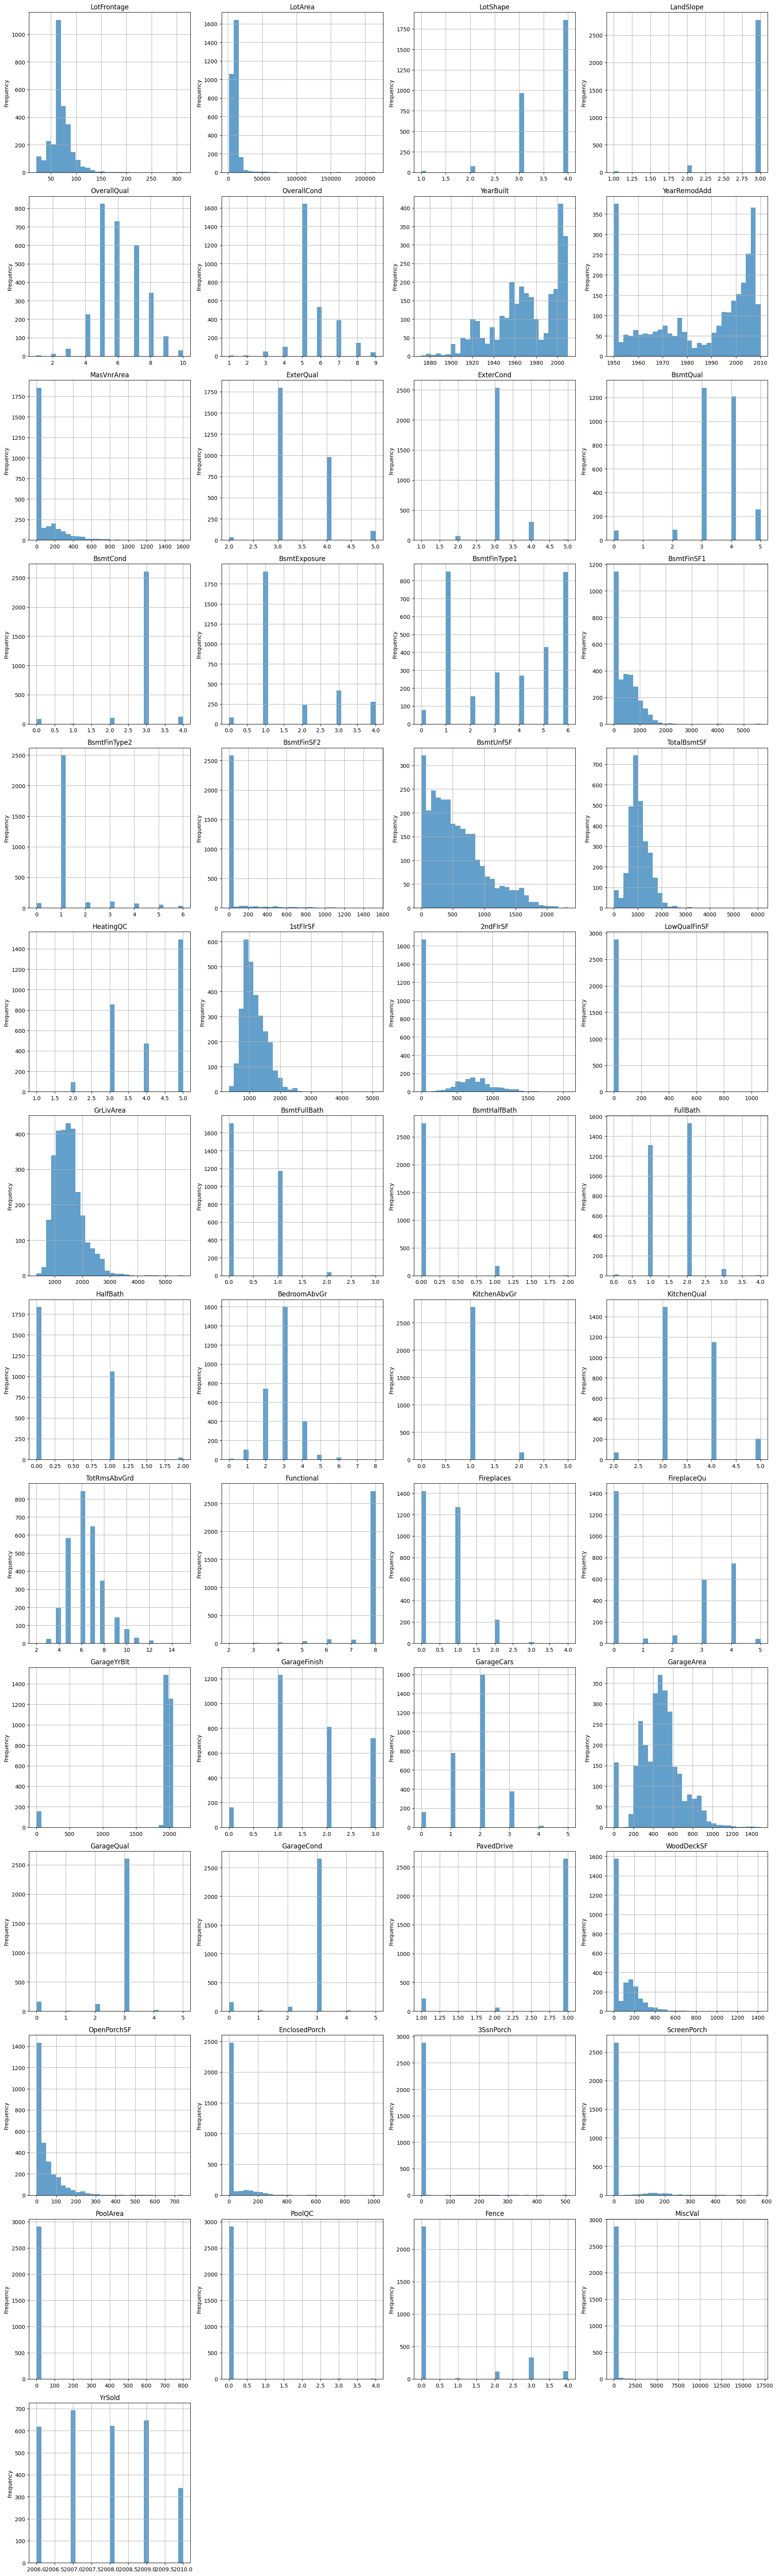

In [11]:
print(f"Analyzing numerical features")

# Create histograms for numerical features
fig, axes = plt.subplots(
    nrows=len(numerical_features) // 4 + 1,
    ncols=4,
    figsize=(20, 5 * len(numerical_features) // 4),
)
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if idx < len(axes):
        df_all[feature].hist(bins=30, ax=axes[idx], alpha=0.7)
        axes[idx].set_title(f"{feature}", fontsize=12)
        axes[idx].set_ylabel("Frequency")

# Hide empty subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

### (3.3) Categorical Features Distribution

Analyzing categorical features' distribution


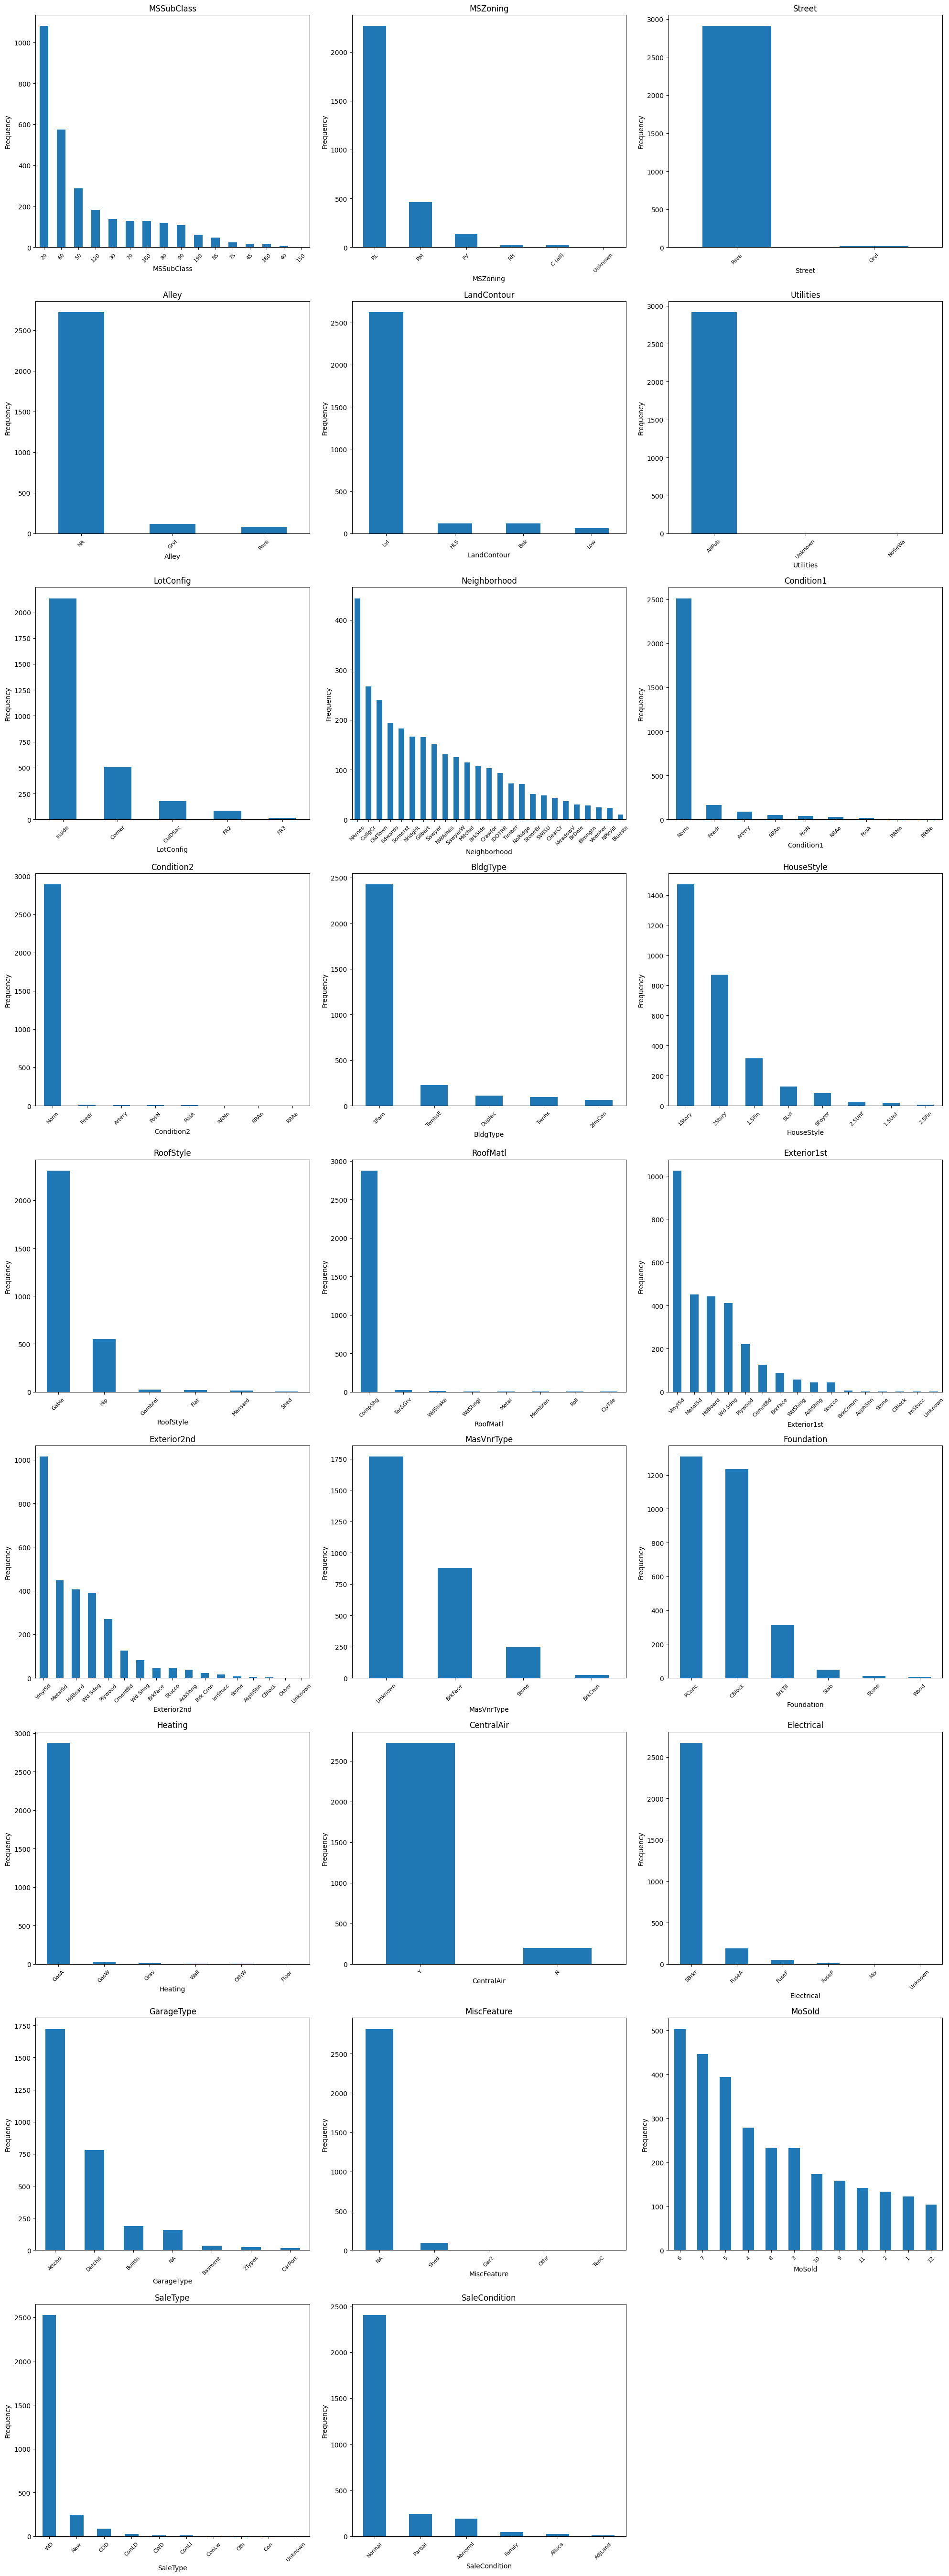

In [12]:
print(f"Analyzing categorical features' distribution")

# Create bar plots for categorical features
n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows))
axes = axes.ravel() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, feature in enumerate(categorical_features):
    if idx < len(axes):
        value_counts = df_all[feature].value_counts()
        value_counts.plot(kind="bar", ax=axes[idx], rot=45)
        axes[idx].set_title(f"{feature}", fontsize=12)
        axes[idx].set_ylabel("Frequency")
        axes[idx].tick_params(axis="x", labelsize=8)

# Hide empty subplots
for idx in range(len(categorical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

<hr>

## (4) Target & Relationship Analysis

### (4.1) Target Analysis

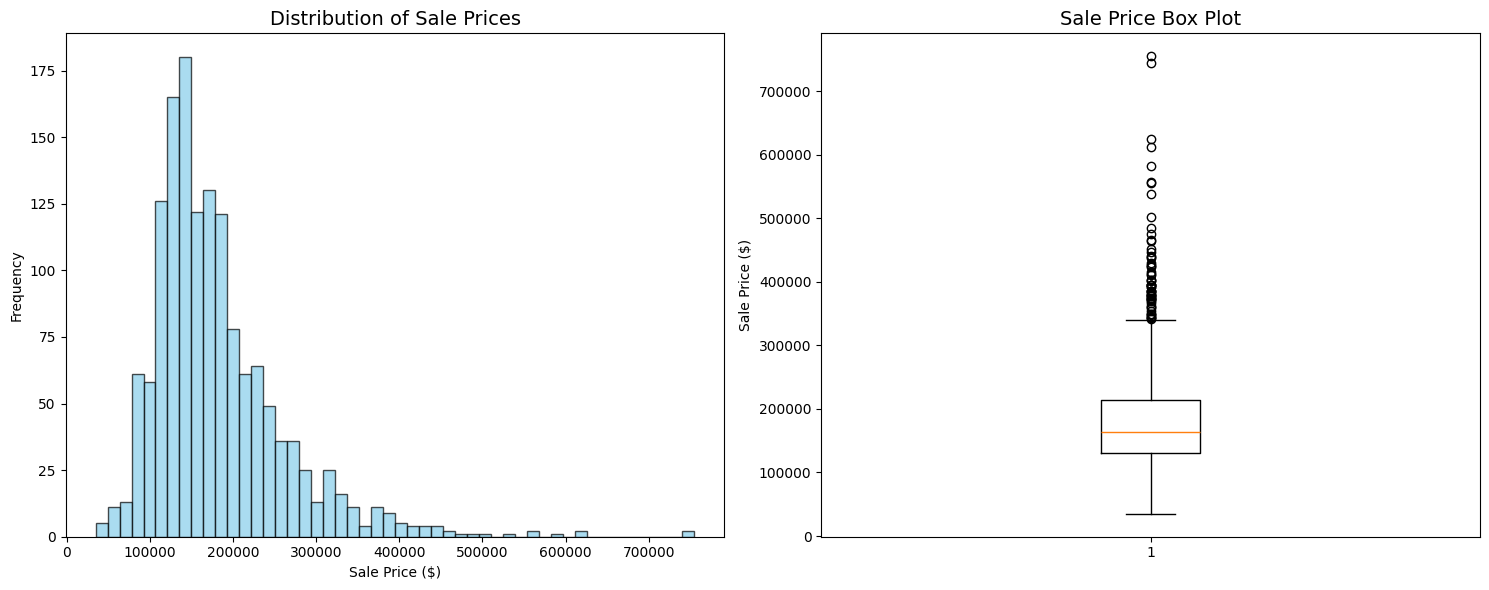

SalePrice Summary Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [13]:
# Recover training data for target analysis
train_data = df_all.head(len(train_df))

# Analyze SalePrice distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
axes[0].hist(
    train_data["SalePrice"], bins=50, alpha=0.7, color="skyblue", edgecolor="black"
)
axes[0].set_title("Distribution of Sale Prices", fontsize=14)
axes[0].set_xlabel("Sale Price ($)")
axes[0].set_ylabel("Frequency")

# Box plot
axes[1].boxplot(train_data["SalePrice"])
axes[1].set_title("Sale Price Box Plot", fontsize=14)
axes[1].set_ylabel("Sale Price ($)")

plt.tight_layout()
plt.show()

# Summary statistics
print("SalePrice Summary Statistics:")
print(train_data["SalePrice"].describe())

In [14]:
# Calculate skewness with proper type handling
price_skewness = float(train_data["SalePrice"].skew())  # Convert to float
print(f"SalePrice Skewness: {price_skewness:.3f}")

# Type-safe comparison
if abs(price_skewness) > 0.5:
    print(
        "SalePrice is significantly skewed. Consider log transformation for modeling."
    )
else:
    print("SalePrice distribution is relatively normal.")

SalePrice Skewness: 1.883
SalePrice is significantly skewed. Consider log transformation for modeling.


### (4.2) Correlations

In [15]:
numerical_features_with_target = train_data.select_dtypes(include=[np.number]).columns
numerical_features_with_target = numerical_features_with_target.drop(
    "Id", errors="ignore"
)

correlations = (
    train_data[numerical_features_with_target].corr()["SalePrice"].drop("SalePrice")
)


strong_positive = correlations[correlations >= 0.5]


moderate_positive = correlations[(correlations >= 0.3) & (correlations < 0.5)]


weak = correlations[abs(correlations) < 0.3]


moderate_negative = correlations[(correlations <= -0.3) & (correlations > -0.5)]


strong_negative = correlations[correlations <= -0.5]


print(f"Correlation Analysis:")
print(f"Strong positive (≥0.5): {len(strong_positive)} features")
print(f"Moderate positive (0.3-0.5): {len(moderate_positive)} features")
print(f"Weak (-0.3 to 0.3): {len(weak)} features")
print(f"Moderate negative (-0.5 to -0.3): {len(moderate_negative)} features")
print(f"Strong negative (≤-0.5): {len(strong_negative)} features")

if len(strong_positive) > 0:
    print(f"\nSTRONGEST POSITIVE correlations:")
    print(strong_positive.sort_values(ascending=False))


if len(strong_negative) > 0:
    print(f"\nSTRONGEST NEGATIVE correlations:")
    print(strong_negative.sort_values(ascending=True))

else:
    print(f"\nNo strong negative correlations found")

Correlation Analysis:
Strong positive (≥0.5): 17 features
Moderate positive (0.3-0.5): 10 features
Weak (-0.3 to 0.3): 28 features
Moderate negative (-0.5 to -0.3): 0 features
Strong negative (≤-0.5): 2 features

STRONGEST POSITIVE correlations:
OverallQual       0.790982
TotalSF           0.782259
GrLivArea         0.708624
ExterQual         0.682639
KitchenQual       0.659600
GarageCars        0.640409
TotalBathrooms    0.631731
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
BsmtQual          0.585207
FullBath          0.560664
GarageFinish      0.549247
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
FireplaceQu       0.520438
YearRemodAdd      0.507101
Name: SalePrice, dtype: float64

STRONGEST NEGATIVE correlations:
HouseAge   -0.523350
RemodAge   -0.509079
Name: SalePrice, dtype: float64


Features with |correlation| > 0.5:
OverallQual            0.791 (Strong +)
TotalSF                0.782 (Strong +)
GrLivArea              0.709 (Strong +)
ExterQual              0.683 (Strong +)
KitchenQual            0.660 (Strong +)
GarageCars             0.640 (Strong +)
TotalBathrooms         0.632 (Strong +)
GarageArea             0.623 (Strong +)
TotalBsmtSF            0.614 (Strong +)
1stFlrSF               0.606 (Strong +)


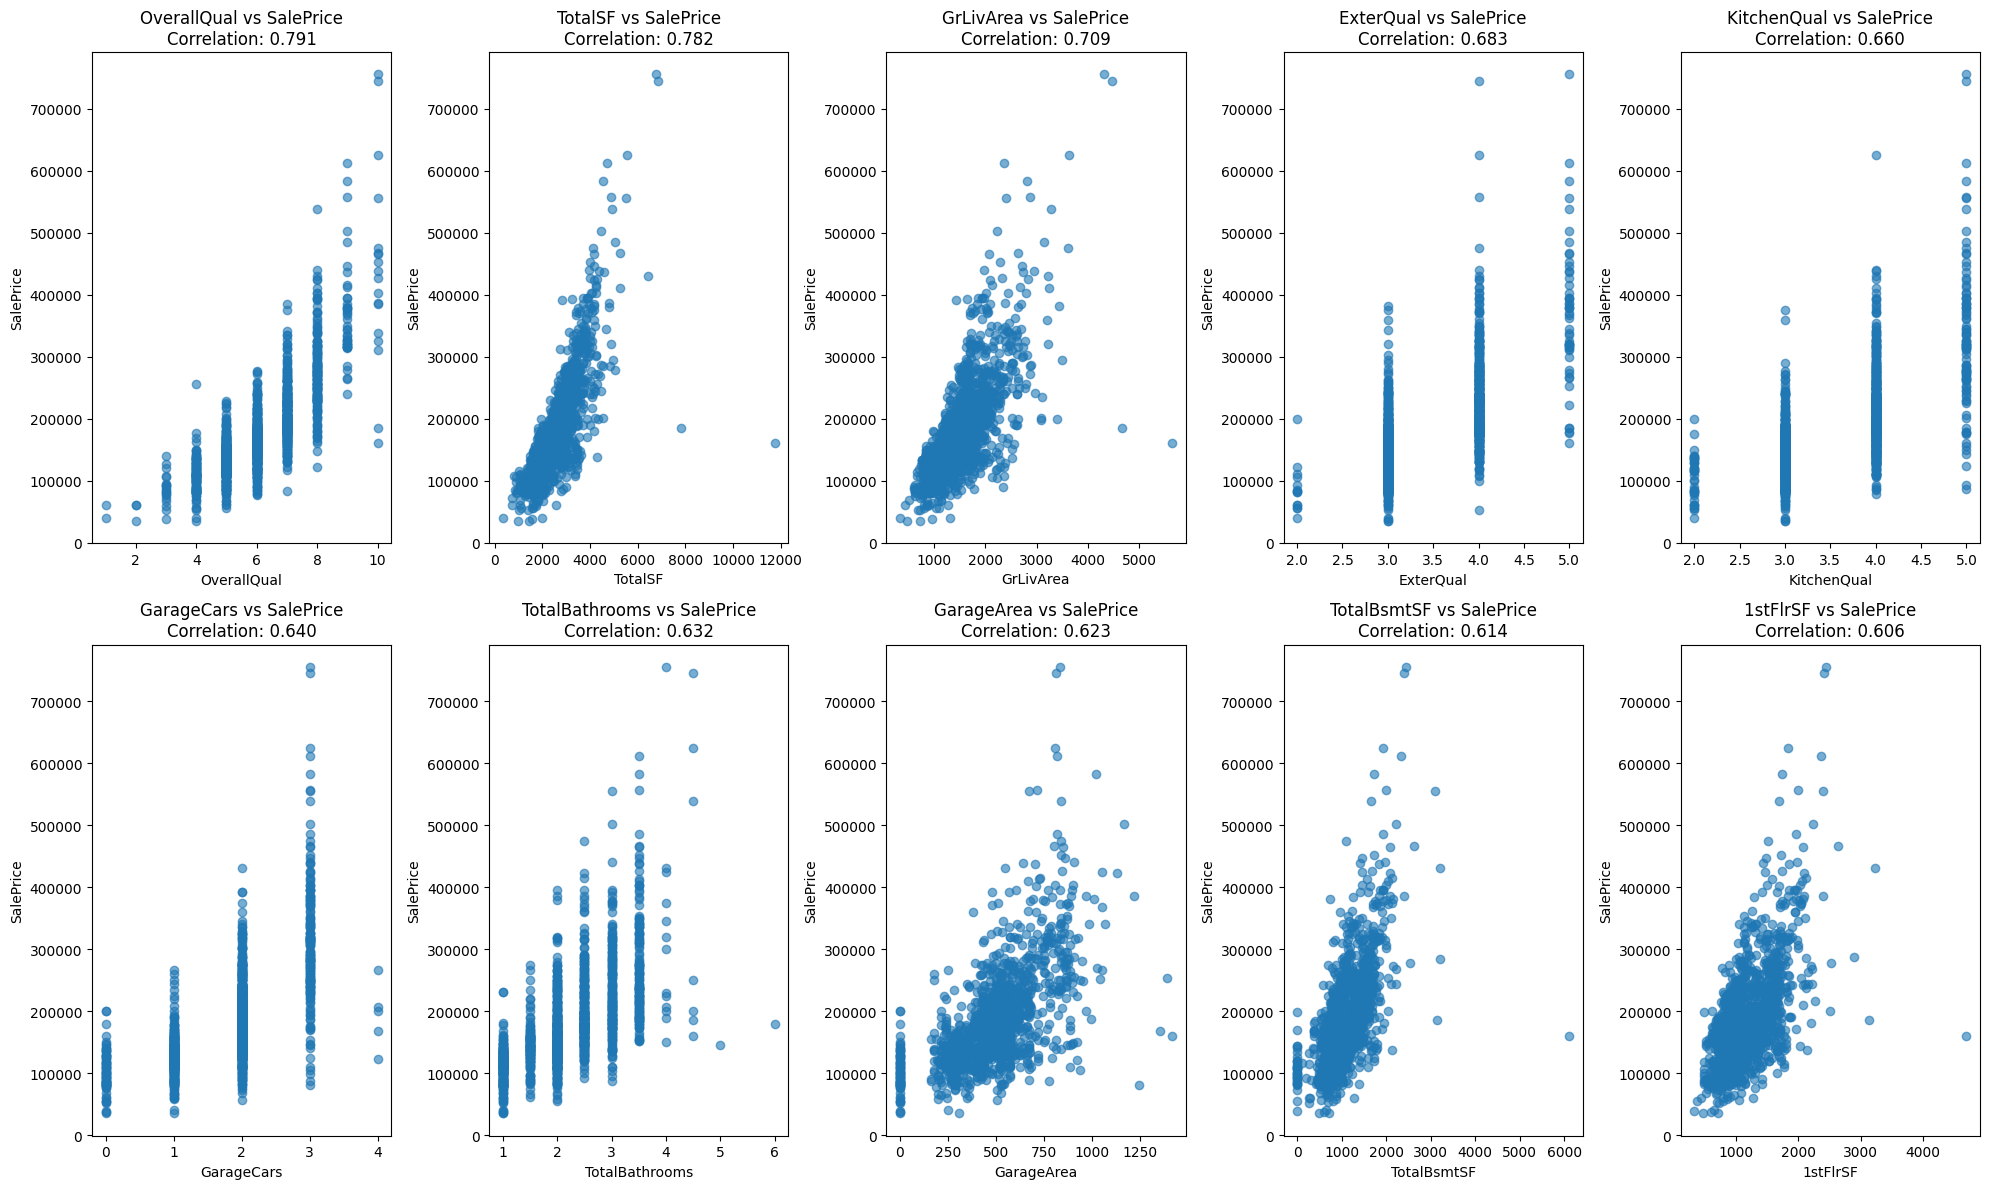

In [16]:
# Get features with correlation strength > 0.5 (ignoring sign)
strong_correlations = correlations[abs(correlations) > 0.5]
top_features = strong_correlations.abs().sort_values(ascending=False).head(10).index

print(f"Features with |correlation| > 0.5:")
for feature in top_features:
    corr_val = correlations[feature]
    strength = (
        "Strong +"
        if corr_val > 0.5
        else (
            "Moderate +"
            if corr_val > 0.3
            else (
                "Strong -"
                if corr_val < -0.5
                else "Moderate -" if corr_val < -0.3 else "Weak"
            )
        )
    )
    print(f"{feature:<20} {corr_val:>7.3f} ({strength})")


fig, axes = plt.subplots(2, 5, figsize=(20, 12))

axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(train_data[feature], train_data["SalePrice"], alpha=0.6)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("SalePrice")
    axes[idx].set_title(
        f"{feature} vs SalePrice\nCorrelation: {correlations[feature]:.3f}"
    )


plt.tight_layout()
plt.show()

### (4.3) Categorical Feature Analysis

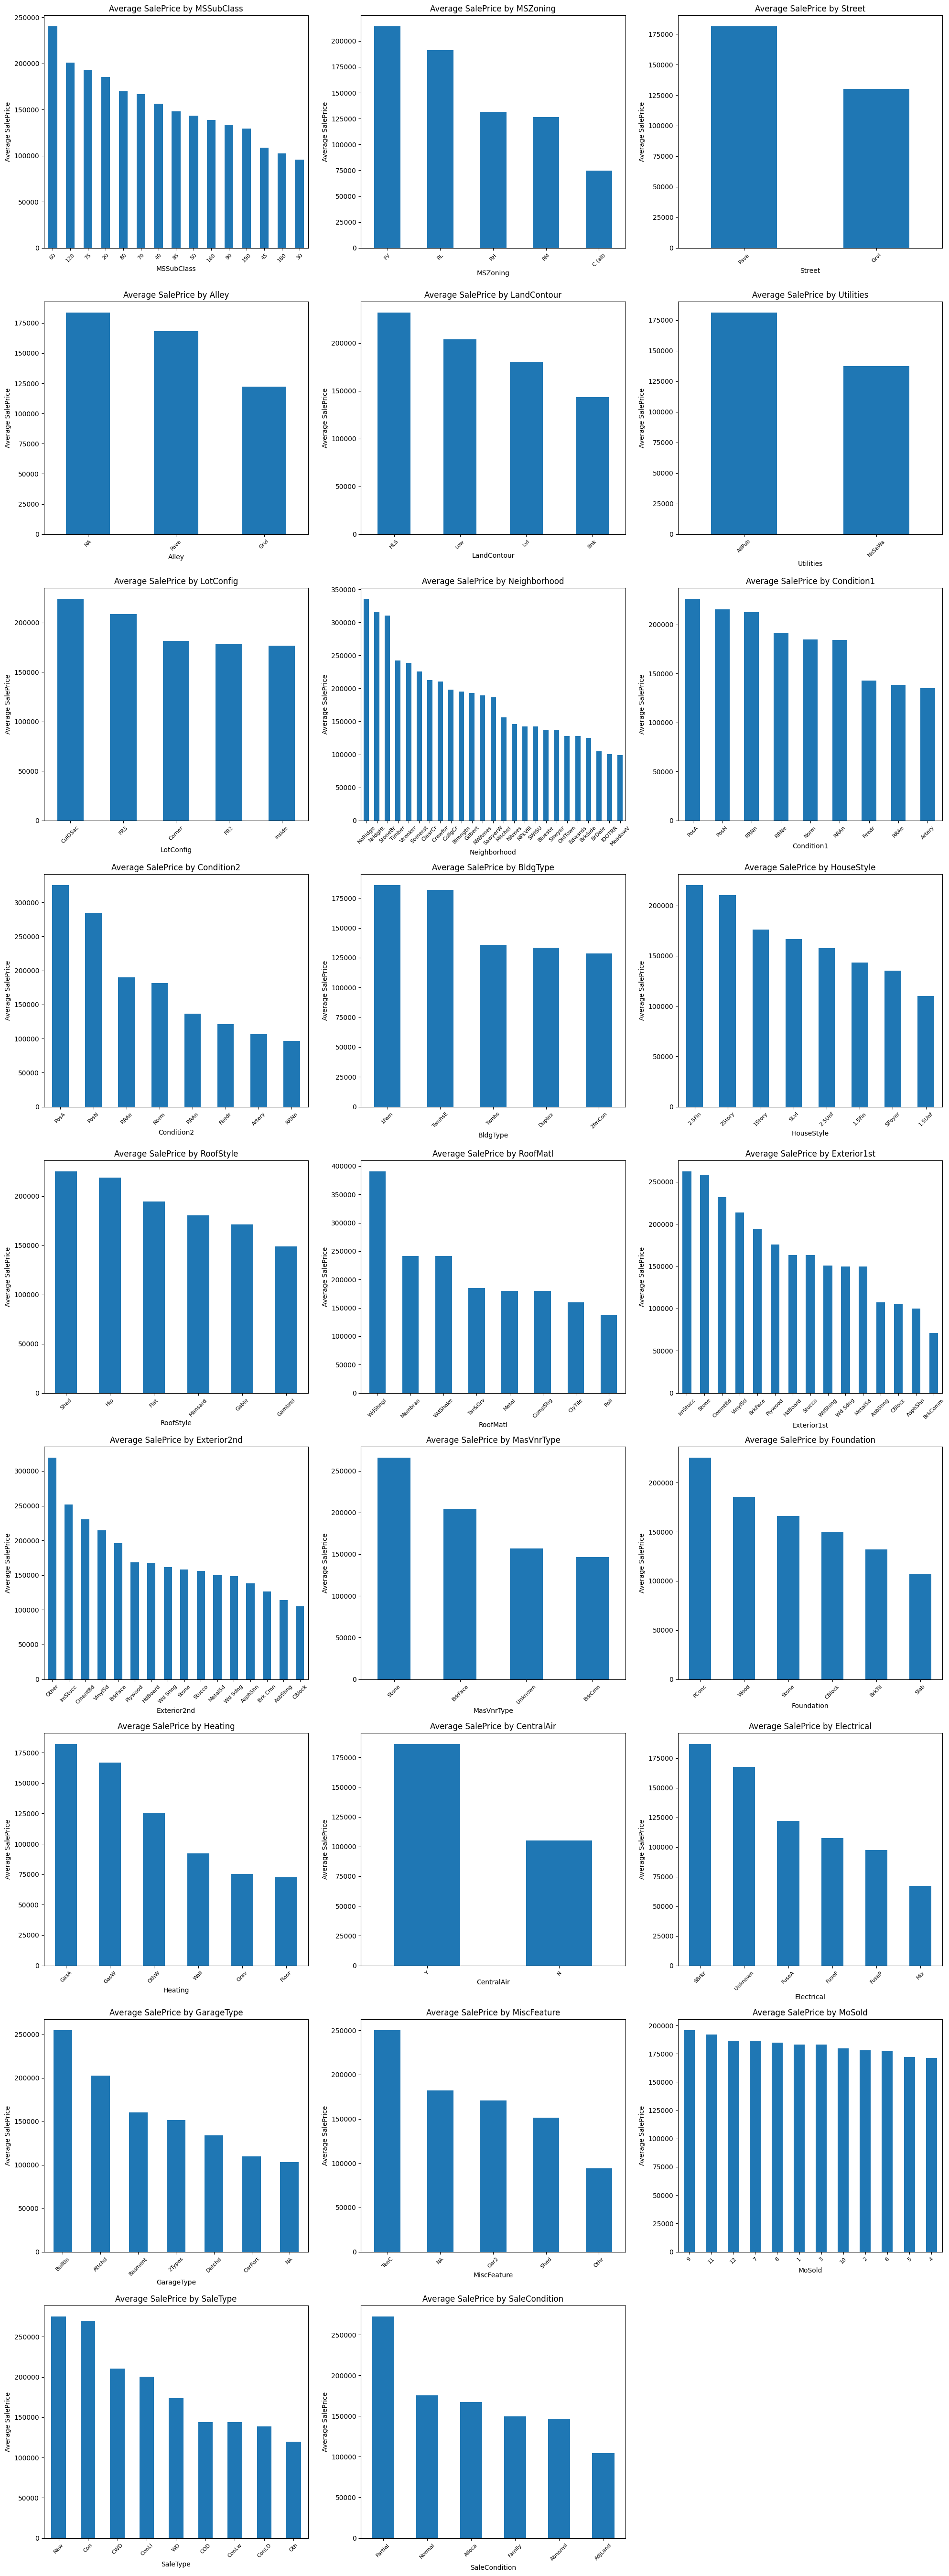

In [17]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows))
axes = axes.ravel() if n_rows > 1 else [axes] if n_rows == 1 else axes


for idx, feature in enumerate(categorical_features):

    if idx < len(axes):

        # Calculate mean price by category
        category_means = (
            train_data.groupby(feature)["SalePrice"].mean().sort_values(ascending=False)
        )

        # Create the plot

        category_means.plot(kind="bar", ax=axes[idx], rot=45)

        axes[idx].set_title(f"Average SalePrice by {feature.replace('_Cat', '')}")

        axes[idx].set_ylabel("Average SalePrice")

        axes[idx].tick_params(axis="x", labelsize=8)

# Hide empty subplot


if len(categorical_features) < len(axes):

    axes[-1].set_visible(False)


plt.tight_layout()


plt.show()

<hr>

## (5) Export & Summary

### (5.1) Export

In [18]:
# Split back into train and test sets
processed_train = df_all.head(len(train_df))
processed_test = df_all.tail(len(test_df))

print(f"Processed training data shape: {processed_train.shape}")
print(f"Processed test data shape: {processed_test.shape}")

# Save processed data
processed_train.to_csv("processed/processed_train.csv", index=False)
processed_test.to_csv("processed/processed_test.csv", index=False)

print("Data successfully processed and saved!")
print("Files created:")
print("- processed/processed_train.csv: Training data ready for modeling")
print("- processed/processed_test.csv: Test data ready for predictions")

Processed training data shape: (1460, 85)
Processed test data shape: (1459, 85)
Data successfully processed and saved!
Files created:
- processed/processed_train.csv: Training data ready for modeling
- processed/processed_test.csv: Test data ready for predictions


### (5.2) Summary

- __Data Quality:__ Successfully handled missing values using domain knowledge
- __Feature Types:__ Converted categorical identifiers and ordinal features appropriately
- __Target Variable:__ SalePrice shows right skewness - consider log transformation for modeling
- __Strong Predictors:__ OverallQual, GrLivArea, GarageCars, TotalBsmtSF show high correlation with price
- __Categorical Importance:__ Neighborhood and quality ratings significantly impact price

### (5.3) Recommendations for Modeling:

- __Feature Selection:__ Focus on high-correlation numerical features and key categorical variables
- __Preprocessing:__ Consider log transformation of SalePrice and skewed numerical features
- __Encoding:__ Use appropriate encoding for remaining categorical variables (one-hot, target encoding)
- __Validation:__ Implement proper cross-validation strategy
- __Models:__ Try ensemble methods (Random Forest, Gradient Boosting) for this type of structured data